Cargar las df, hacer merge y shuffle

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import numpy as np

normal_df = pd.read_csv('data/ptbdb_normal.csv', header=None)
abnormal_df = pd.read_csv('data/ptbdb_abnormal.csv', header=None)

df = pd.concat([normal_df, abnormal_df], axis=0).sample(frac=1).reset_index(drop=True)

X = df.iloc[:, :-1]
y = df.iloc[:, -1]   # The last column as labels (0 = normal, 1 = abnormal)




Contar las instancias

Conteo de instancias de cada clase:
187
1.0    10506
0.0     4046
Name: count, dtype: int64


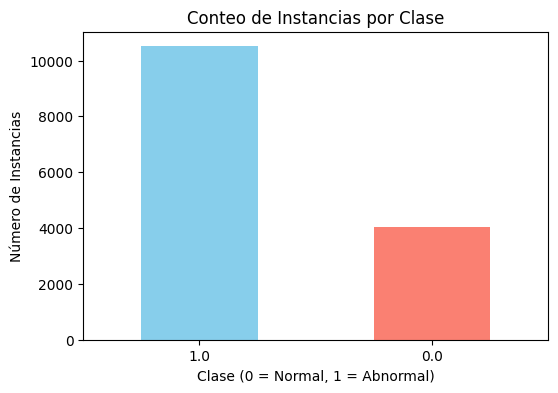

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar la cantidad de instancias de cada clase (0 = normal, 1 = abnormal)
class_counts = df.iloc[:, -1].value_counts()

print("Conteo de instancias de cada clase:")
print(class_counts)

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Conteo de Instancias por Clase')
plt.xlabel('Clase (0 = Normal, 1 = Abnormal)')
plt.ylabel('Número de Instancias')
plt.xticks(rotation=0)
plt.show()


Probar el modelo con SMOTE

In [2]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models = {
    'Random Forest': RandomForestClassifier(),
}

kf = StratifiedKFold(n_splits=5, shuffle=True)

for model_name, model in models.items():
    print(f'----- {model_name} -----')
    cv_y_test = []
    cv_y_pred = []

    for train_index, test_index in kf.split(X, y):
        x_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index, :]
        y_test = y.iloc[test_index]

        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # Apply SMOTE for balancing the training set
        smote = SMOTE()
        x_train_res, y_train_res = smote.fit_resample(x_train_scaled, y_train)

        model.fit(x_train_res, y_train_res)

        y_pred = model.predict(x_test_scaled)

        cv_y_test.append(y_test)
        cv_y_pred.append(y_pred)

    print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

----- Random Forest -----
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      4046
         1.0       0.98      0.98      0.98     10506

    accuracy                           0.97     14552
   macro avg       0.96      0.97      0.96     14552
weighted avg       0.97      0.97      0.97     14552



Probar el modelo sin SMOTE

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
import numpy as np

# Step 3: Preprocess data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Model training and evaluation with cross-validation
models = {
    'Random Forest': RandomForestClassifier(),
}

kf = StratifiedKFold(n_splits=5, shuffle=True)

for model_name, model in models.items():
    print(f'----- {model_name} -----')
    cv_y_test = []
    cv_y_pred = []

    for train_index, test_index in kf.split(X, y):
        # Separate training and test data
        x_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index]
        x_test = X.iloc[test_index, :]
        y_test = y.iloc[test_index]

        # Scale the data
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # Train the model without balancing
        model.fit(x_train_scaled, y_train)

        # Predict on the test set
        y_pred = model.predict(x_test_scaled)

        cv_y_test.append(y_test)
        cv_y_pred.append(y_pred)

    # Print classification report
    print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))


----- Random Forest -----
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      4046
         1.0       0.97      0.99      0.98     10506

    accuracy                           0.97     14552
   macro avg       0.97      0.96      0.97     14552
weighted avg       0.97      0.97      0.97     14552



Probar que no tengamos overfitting.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Step 1: Dividir la base de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Preprocesar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Definir los modelos
models = {
    'Random Forest': RandomForestClassifier(),
}

# Step 4: Evaluación del modelo con validación cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f'----- {model_name} -----')
    cv_y_test = []
    cv_y_pred = []

    for train_index, test_index in kf.split(X_train_scaled, y_train):
        # Separar datos de entrenamiento y validación dentro del conjunto de entrenamiento
        x_train_fold, x_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Entrenar el modelo
        model.fit(x_train_fold, y_train_fold)

        # Predecir en el conjunto de validación
        y_pred_fold = model.predict(x_val_fold)

        cv_y_test.append(y_val_fold)
        cv_y_pred.append(y_pred_fold)

    # Imprimir informe de clasificación basado en validación cruzada
    print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

# Step 5: Evaluación final en el conjunto de prueba
for model_name, model in models.items():
    print(f'----- {model_name} en el conjunto de prueba -----')

    # Entrenar el modelo con todos los datos de entrenamiento
    model.fit(X_train_scaled, y_train)

    # Predecir en el conjunto de prueba
    y_test_pred = model.predict(X_test_scaled)

    # Imprimir informe de clasificación
    print(classification_report(y_test, y_test_pred))


----- Random Forest -----
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      3237
         1.0       0.97      0.99      0.98      8404

    accuracy                           0.97     11641
   macro avg       0.97      0.96      0.96     11641
weighted avg       0.97      0.97      0.97     11641

----- Random Forest en el conjunto de prueba -----
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       809
         1.0       0.97      0.99      0.98      2102

    accuracy                           0.97      2911
   macro avg       0.97      0.96      0.96      2911
weighted avg       0.97      0.97      0.97      2911



----- Random Forest -----
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76      3237
         1.0       0.90      0.92      0.91      8404

    accuracy                           0.87     11641
   macro avg       0.84      0.83      0.83     11641
weighted avg       0.87      0.87      0.87     11641

----- Random Forest en el conjunto de prueba -----
              precision    recall  f1-score   support

         0.0       0.79      0.76      0.77       809
         1.0       0.91      0.92      0.91      2102

    accuracy                           0.88      2911
   macro avg       0.85      0.84      0.84      2911
weighted avg       0.88      0.88      0.88      2911



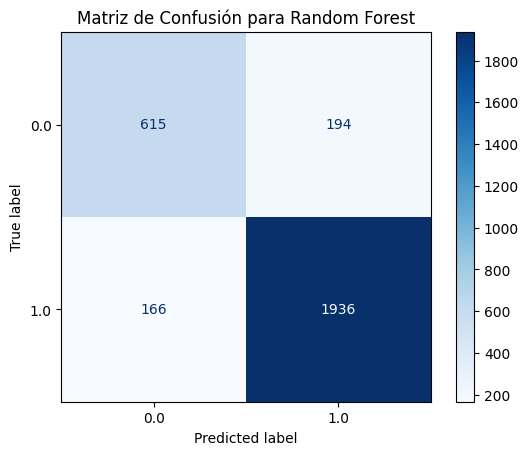

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Dividir la base de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Preprocesar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Definir los modelos con regularización y/o simplificación
models = {
    'Random Forest': RandomForestClassifier(max_depth=5, min_samples_leaf=10),  # Pruning parameters added
}

# Step 4: Evaluación del modelo con validación cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f'----- {model_name} -----')
    cv_y_test = []
    cv_y_pred = []

    for train_index, test_index in kf.split(X_train_scaled, y_train):
        # Separar datos de entrenamiento y validación dentro del conjunto de entrenamiento
        x_train_fold, x_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Entrenar el modelo
        model.fit(x_train_fold, y_train_fold)

        # Predecir en el conjunto de validación
        y_pred_fold = model.predict(x_val_fold)

        cv_y_test.append(y_val_fold)
        cv_y_pred.append(y_pred_fold)

    # Imprimir informe de clasificación basado en validación cruzada
    print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

# Step 5: Evaluación final en el conjunto de prueba y mostrar matriz de confusión
for model_name, model in models.items():
    print(f'----- {model_name} en el conjunto de prueba -----')

    # Entrenar el modelo con todos los datos de entrenamiento
    model.fit(X_train_scaled, y_train)

    # Predecir en el conjunto de prueba
    y_test_pred = model.predict(X_test_scaled)

    # Imprimir informe de clasificación
    print(classification_report(y_test, y_test_pred))

    # Generar y mostrar la matriz de confusión
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusión para {model_name}')
    plt.show()


Buscar Hiperparametros

In [5]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Step 1: Dividir la base de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Preprocesar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Definir los parámetros para la búsqueda aleatoria
param_dist = {
    'n_estimators': np.arange(100, 301, 50),             
    'max_depth': [None, 10, 20, 30],             
    'min_samples_split': np.arange(2, 11, 3),             
    'min_samples_leaf': [1, 2, 4],               
    'max_features': ['sqrt', 'log2', None],      
    'bootstrap': [True, False]                   
}

# Crear el modelo de Random Forest
rf = RandomForestClassifier(random_state=42)

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=5, scoring='precision', n_jobs=-1, verbose=2, random_state=42)

# Entrenar el modelo con la búsqueda aleatoria
random_search.fit(X_train_scaled, y_train)

# Imprimir los mejores parámetros encontrados
print(f"Mejores hiperparámetros: {random_search.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}


Probar modelo con hiperparametros

----- Random Forest -----
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      3237
         1.0       0.97      0.99      0.98      8404

    accuracy                           0.97     11641
   macro avg       0.98      0.96      0.97     11641
weighted avg       0.97      0.97      0.97     11641

----- Random Forest en el conjunto de prueba -----
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95       809
         1.0       0.97      0.99      0.98      2102

    accuracy                           0.97      2911
   macro avg       0.97      0.96      0.96      2911
weighted avg       0.97      0.97      0.97      2911



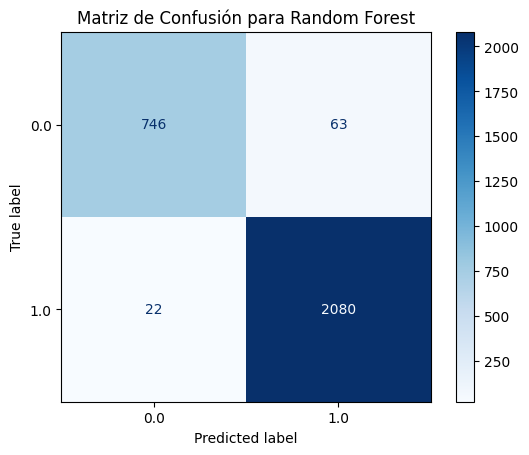

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Dividir la base de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Preprocesar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Definir los modelos con los mejores hiperparámetros
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=250,       # Mejor número de árboles
        max_depth=None,         # Sin límite de profundidad
        min_samples_split=2,    # Mínimo de muestras para dividir un nodo
        min_samples_leaf=1,     # Mínimo de muestras en cada hoja
        max_features='log2',    # Máximo número de características para dividir
        bootstrap=False,        # No reutilizar muestras en el bosque
        random_state=42         # Para replicabilidad
    )
}

# Step 4: Evaluación del modelo con validación cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f'----- {model_name} -----')
    cv_y_test = []
    cv_y_pred = []

    for train_index, test_index in kf.split(X_train_scaled, y_train):
        # Separar datos de entrenamiento y validación dentro del conjunto de entrenamiento
        x_train_fold, x_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Entrenar el modelo
        model.fit(x_train_fold, y_train_fold)

        # Predecir en el conjunto de validación
        y_pred_fold = model.predict(x_val_fold)

        cv_y_test.append(y_val_fold)
        cv_y_pred.append(y_pred_fold)

    # Imprimir informe de clasificación basado en validación cruzada
    print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

# Step 5: Evaluación final en el conjunto de prueba y mostrar matriz de confusión
for model_name, model in models.items():
    print(f'----- {model_name} en el conjunto de prueba -----')

    # Entrenar el modelo con todos los datos de entrenamiento
    model.fit(X_train_scaled, y_train)

    # Predecir en el conjunto de prueba
    y_test_pred = model.predict(X_test_scaled)

    # Imprimir informe de clasificación
    print(classification_report(y_test, y_test_pred))

    # Generar y mostrar la matriz de confusión
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusión para {model_name}')
    plt.show()


Support Vector Classifier

Observamos que el modelo se equivoca poco.

----- Support Vector Classifier (SVC) -----
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84      3237
         1.0       0.93      0.96      0.94      8404

    accuracy                           0.91     11641
   macro avg       0.90      0.88      0.89     11641
weighted avg       0.91      0.91      0.91     11641

----- Support Vector Classifier (SVC) en el conjunto de prueba -----
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       809
         1.0       0.93      0.96      0.95      2102

    accuracy                           0.93      2911
   macro avg       0.92      0.89      0.90      2911
weighted avg       0.92      0.93      0.92      2911



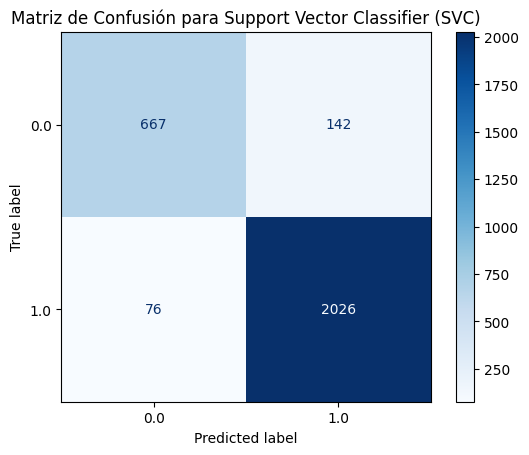

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Dividir la base de datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Preprocesar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Definir los modelos con regularización y/o simplificación
models = {
    'Support Vector Classifier (SVC)': SVC(kernel='rbf', C=1.0, gamma='scale')  # SVC with RBF kernel
}

# Step 4: Evaluación del modelo con validación cruzada
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f'----- {model_name} -----')
    cv_y_test = []
    cv_y_pred = []

    for train_index, test_index in kf.split(X_train_scaled, y_train):
        # Separar datos de entrenamiento y validación dentro del conjunto de entrenamiento
        x_train_fold, x_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Entrenar el modelo
        model.fit(x_train_fold, y_train_fold)

        # Predecir en el conjunto de validación
        y_pred_fold = model.predict(x_val_fold)

        cv_y_test.append(y_val_fold)
        cv_y_pred.append(y_pred_fold)

    # Imprimir informe de clasificación basado en validación cruzada
    print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

# Step 5: Evaluación final en el conjunto de prueba y mostrar matriz de confusión
for model_name, model in models.items():
    print(f'----- {model_name} en el conjunto de prueba -----')

    # Entrenar el modelo con todos los datos de entrenamiento
    model.fit(X_train_scaled, y_train)

    # Predecir en el conjunto de prueba
    y_test_pred = model.predict(X_test_scaled)

    # Imprimir informe de clasificación
    print(classification_report(y_test, y_test_pred))

    # Generar y mostrar la matriz de confusión
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusión para {model_name}')
    plt.show()
